# Predicting Carbon based on NDMI, Age, Precipictation, Temperature, and NDVI data

## Importing all the Required packages that we'll use first

In [2]:
import random
import pickle
import time
import pathlib

import pandas as pd
import numpy as np
import rasterio as rio
import tqdm

import matplotlib.pyplot as plt
import matplotlib
# import matplotlib.image as mpimg
# import matplotlib.patches as mpatches
# import matplotlib.ticker as mticker
# import matplotlib.font_manager
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
font = {
    # 'family' : 'normal',
    # 'weight' : 'bold',
    'size'   : 12,
}

# matplotlib.rc('font', **font)

from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

from yellowbrick.regressor import PredictionError
from sklearn.metrics import r2_score

coreLimit = int(336*(3/4)) # Parallel Processing # 336 Total Cores Available

## Creating a Data Handling Class for ease of passing data around. 

In [3]:
class Data():
    def __init__(self, X=None, Y=None):
        if X != None:
            self.__x = X
        else:
            self.__x = 0
        if Y != None:
            self.__y = Y
        else:
            self.__y = 0

    def __del__(self):
        del self.__x, self.__y

    def set_x(self, X):
        self.__x = X

    def set_y(self, Y):
        self.__y = Y
        
    def get_x(self):
        return self.__x

    def get_y(self):
        return self.__y
# end Data

## Reading Data into Memory

        NDVI_Jun13   NDMI_Jun13    PRISM_ppt   PRISM_tave  Carbon (mg/ha)  \
count  8974.000000  8974.000000  8974.000000  8974.000000     8974.000000   
mean   3718.534999  2573.091246  1844.852920     9.865800       52.449871   
std    1008.902601  1038.802994   799.249613     1.604252       33.962805   
min     526.493000 -1539.970000   264.963000     4.600000        0.018302   
25%    3010.157500  2120.062500  1323.510000     9.119900       27.431618   
50%    3767.335000  2821.760000  1818.985000    10.070000       45.324078   
75%    4486.300000  3302.072500  2340.010000    10.850000       71.794848   
max    6254.720000  4616.590000  5057.150000    15.420000      221.266760   

         Stock (%)      Age2018  
count  8974.000000  8974.000000  
mean     56.094156    64.437761  
std      14.186152    38.423668  
min       0.273811     0.000396  
25%      46.412400    36.366150  
50%      58.867250    54.857750  
75%      67.030700    83.978700  
max      94.819600   290.187000  


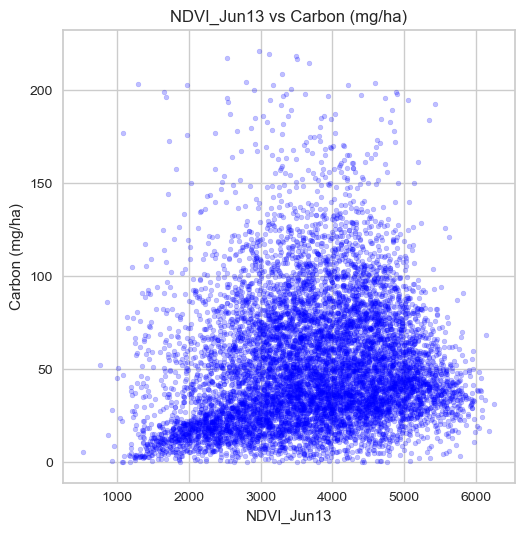

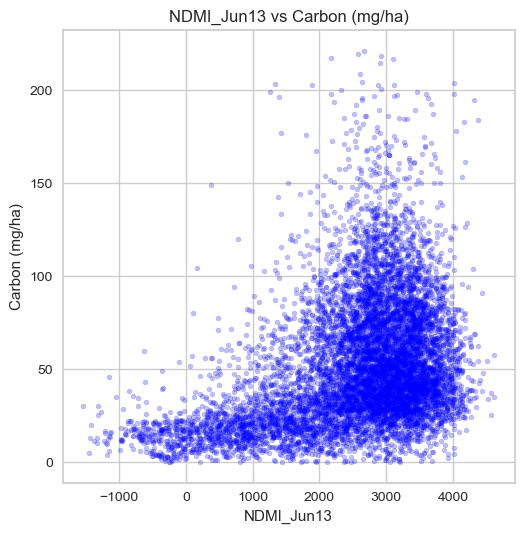

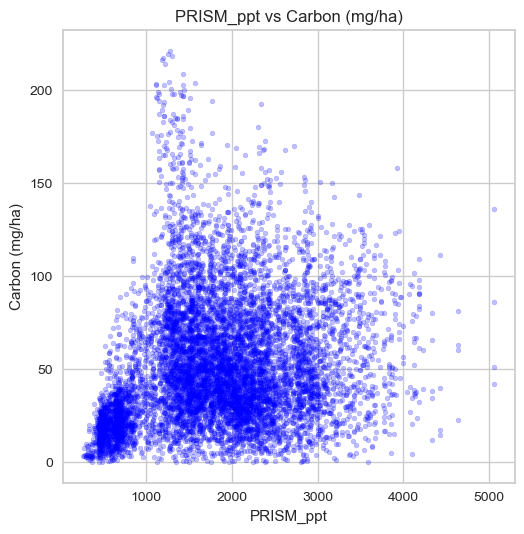

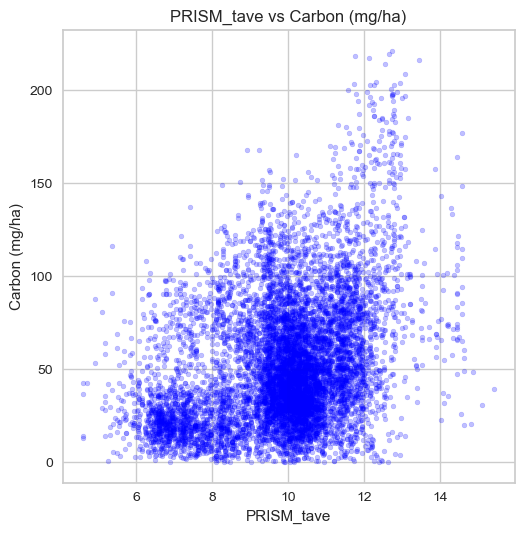

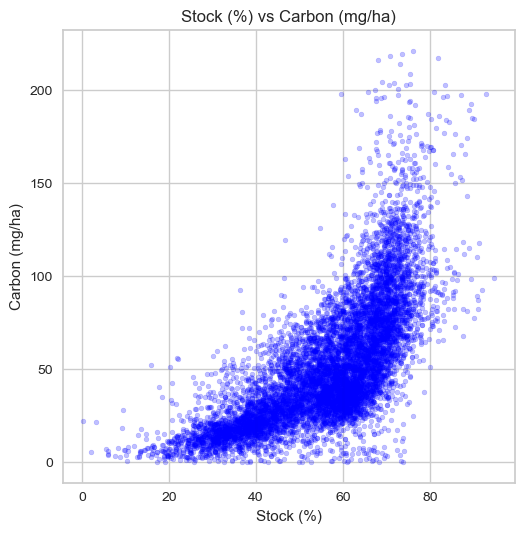

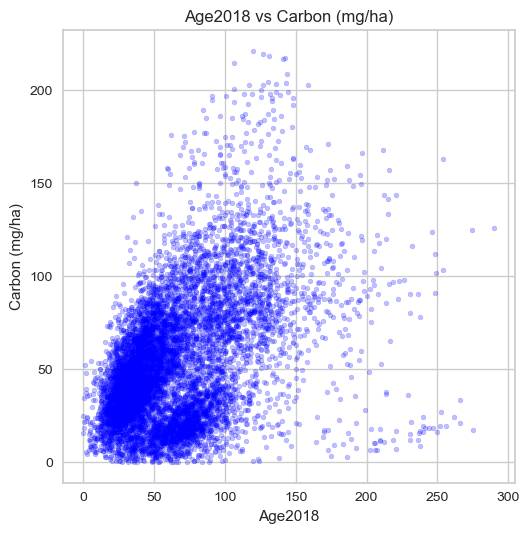

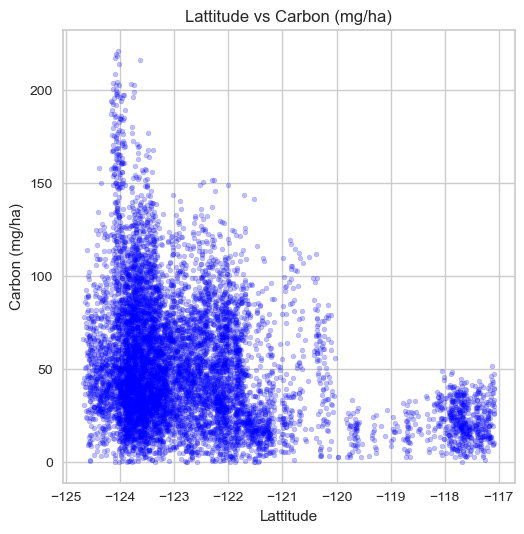

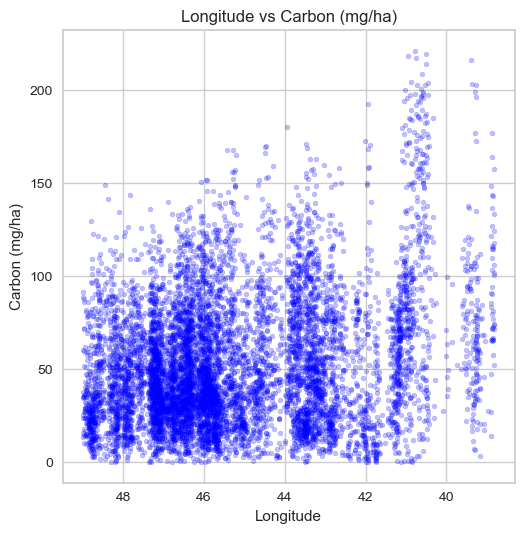

In [4]:
USFS_forest_file = 'data/csv_files/USFS_forest_biomass_mg_ha_Privategt50%_CAORWA_Unburned_random_10K.csv'
USFS_forest = pd.read_csv(USFS_forest_file)

# Removing invalid data (i.e., -9999.0)
count = 0
for i in USFS_forest:
    USFS_forest = USFS_forest[USFS_forest[i] != -9999.0] # Recreating dataset without invalid rows
    if i == 'Age2018' or i == 'biomass_mg':
        USFS_forest = USFS_forest[USFS_forest[i] != 0]
USFS_forest['Carbon2018'] = USFS_forest['Carbon2018']*11.11
USFS_forest = USFS_forest.rename(columns={'Carbon2018': 'Carbon (mg/ha)', 'biomass_mg': 'Biomass (mg/ha)', 'Stock2018': 'Stock (%)', 'POINT_X': 'Lattitude', 'POINT_Y': 'Longitude',})
print(USFS_forest[['NDVI_Jun13', 'NDMI_Jun13', 'PRISM_ppt', 'PRISM_tave', 'Carbon (mg/ha)', 'Stock (%)', 'Age2018',]].describe()) # Post-Removal

# Displaying all the Relevant Data
for k, v in enumerate(USFS_forest):
    if v not in ['id', 'Biomass (mg/ha)', 'Height2018', 'Carbon (mg/ha)']:
        plot1 = plt.scatter(USFS_forest[v], USFS_forest['Carbon (mg/ha)'], label = 'Observed', color = 'blue', marker='.', alpha=0.25)
        plt.gca().set_aspect(aspect=1/plt.gca().get_data_ratio()) # Setting the graph(s) to be a one to one ratio (square)
        plt.xlabel(v)
        plt.ylabel('Carbon (mg/ha)')
        plt.title(str(v)+' vs Carbon (mg/ha)')
        if v == 'Longitude':
            plt.gca().invert_xaxis()
        # plt.legend(handles=[plot1, plot2], loc='best',)
        plt.tight_layout()
        plt.show()
    
# for i in 
# plot1 = plt.scatter(USFS_forest['Age2018'], USFS_forest['Carbon (mg/ha)'], label = 'Observed', color = 'blue', marker='.', alpha=0.25)
# plt.gca().set_aspect(aspect=1/plt.gca().get_data_ratio())
# plt.xlabel('Age2018')
# plt.ylabel('Carbon (mg/ha)')
# plt.title('Observed Age2018 vs Carbon (mg/ha)')
# plt.tight_layout()
# plt.show()

## Splitting the Data

In [197]:
x_train, x_test , y_train, y_test= train_test_split(
    USFS_forest[[
        'NDVI_Jun13', 
        'NDMI_Jun13', 
        'PRISM_ppt', 
        'PRISM_tave', 
        # 'Carbon (mg/ha)', # Possible Y # Uses Mg C per 30x30 Pixel (Conversion factor: 11.11 for Mg/ha)
        # 'Stock (%)',  # Possible Y
        'Age2018', 
        # 'Height2018', # Possible Y
        # 'Biomass (mg/ha)', # Possible Y
        # 'Lattitude',
        # 'Longitude',
    ]], 
    USFS_forest['Carbon (mg/ha)'],
    train_size=0.8, # 80%, 20% data split. 80% for training and 20% for testing
    shuffle=True, # Default: True
)
model_data = Data() # A container for our data
model_data.set_x([x_train, x_test])
model_data.set_y([y_train, y_test])

## Creating a new Model

In [198]:
pipe = Pipeline([
    ("scale", QuantileTransformer()),
    ("model", RandomForestRegressor()),
])  

model = RandomizedSearchCV(
    estimator=pipe,
    param_distributions={
        'scale__n_quantiles': [1000],
        'model__n_estimators': [i for i in range(100, 1000)], 
        'model__max_depth': [i for i in range(1, 2000)],
        'model__max_features':['log2', 'sqrt',]+[i for i in range(1, 1000)],
        'model__min_samples_leaf':[i for i in range (1, 1000)],
        'model__min_samples_split':[i for i in range (2, 1000)],
    },
    refit=True,
    cv=10, # Cross Validations
    n_jobs=coreLimit, # Parallel Processing # 336 Total Cores Available
    verbose=1,
    n_iter=1000, # Number of Iterations (Default: 10)
)
model

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('scale', QuantileTransformer()),
                                             ('model',
                                              RandomForestRegressor())]),
                   n_iter=1000, n_jobs=252,
                   param_distributions={'model__max_depth': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                                                             12, 13, 14, 15, 16,
                                                             17, 18, 19, 20, 21,
                                                             22, 23, 24, 25, 26,
                                                             27, 28, 29, 30, ...],
                                        'model__max_features': ['log2', 'sqrt',
                                                                1, 2, 3, 4, 5,
                                                                6, 7, 8, 9, 10,
                                                                11, 12, 13, 14,
                                                                15, 16, 17, 18...
                                                                    15, 16, 17,
                                                                    18, 19, 20,
                                                                    21, 22, 23,
                                                                    24, 25, 26,
                                                                    27, 28, 29,
                                                                    30, ...],
                                        'model__min_samples_split': [2, 3, 4, 5,
                                                                     6, 7, 8, 9,
                                                                     10, 11, 12,
                                                                     13, 14, 15,
                                                                     16, 17, 18,
                                                                     19, 20, 21,
                                                                     22, 23, 24,
                                                                     25, 26, 27,
                                                                     28, 29, 30,
                                                                     31, ...],
                                        'model__n_estimators': [100, 101, 102,
                                                                103, 104, 105,
                                                                106, 107, 108,
                                                                109, 110, 111,
                                                                112, 113, 114,
                                                                115, 116, 117,
                                                                118, 119, 120,
                                                                121, 122, 123,
                                                                124, 125, 126,
                                                                127, 128, 129, ...],
                                        'scale__n_quantiles': [1000]},
                   verbose=1)

## Fitting the Model to the Data

In [199]:
timeStart = time.time()
carbon_rf = model.fit(model_data.get_x()[0], model_data.get_y()[0])
print('Fit completed in '+str(round((time.time()-timeStart)//60))+' minutes and '+str(round((time.time()-timeStart)%60, 1))+' seconds.')
results = pd.DataFrame(carbon_rf.cv_results_) # Saving the cross validation results for later

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits
Fit completed in 3 minutes and 31.9 seconds.


## Predicting and Generating Graphs

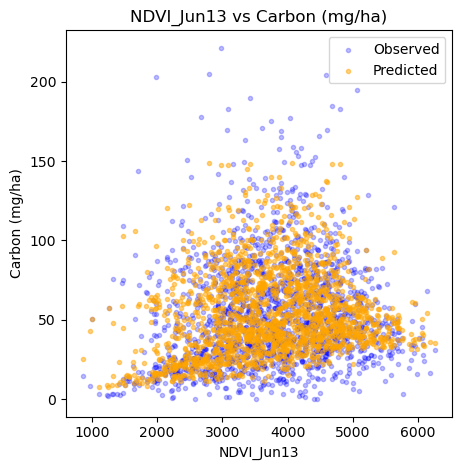

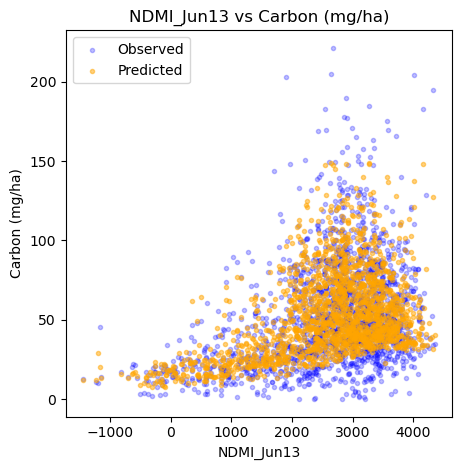

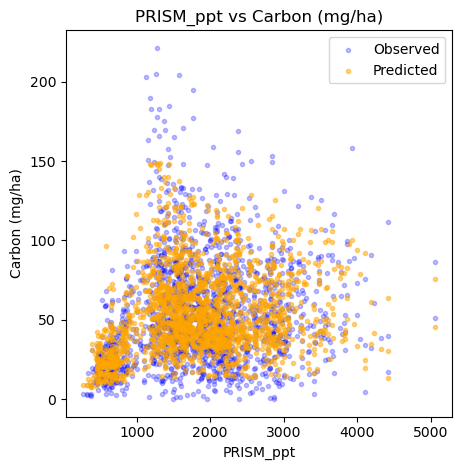

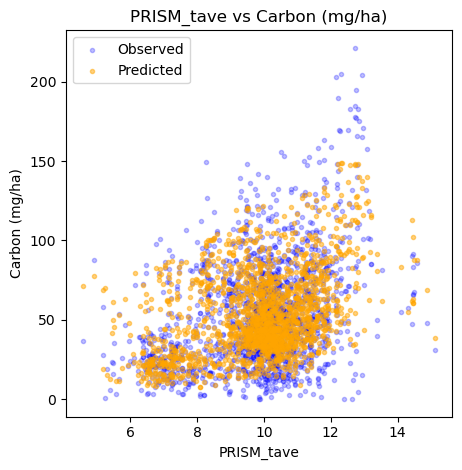

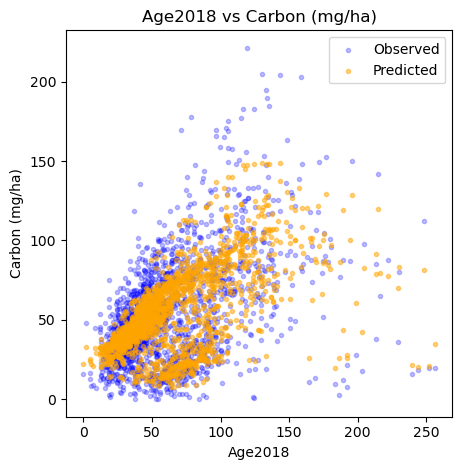

In [200]:
pred = model.predict(model_data.get_x()[1])

for k, v in enumerate(model_data.get_x()[1]):
    plot1 = plt.scatter(model_data.get_x()[1][v], model_data.get_y()[1], label = 'Observed', color = 'blue', marker='.', alpha=0.25)
    plot2 = plt.scatter(model_data.get_x()[1][v], pred, label = 'Predicted', color = 'orange', marker='.', alpha=0.5)
    plt.gca().set_aspect(aspect=1/plt.gca().get_data_ratio()) # Setting the graph(s) to be a one to one ratio (square)
    plt.xlabel(v)
    plt.ylabel('Carbon (mg/ha)')
    plt.title(str(v)+' vs Carbon (mg/ha)')
    if v == 'Longitude':
        plt.gca().invert_xaxis()
    plt.legend(handles=[plot1, plot2], loc='best',)
    plt.tight_layout()
    plt.show()

## Visualizing Errors

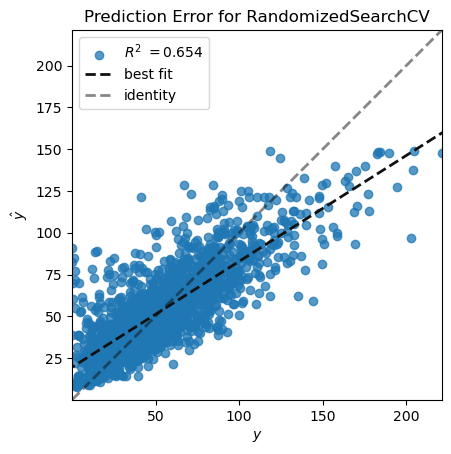

0.6544993251436138


In [201]:
# Plotting the prediction errors (Want 1:1)
visualizer = PredictionError(carbon_rf)
# visualizer.fit(model_data.get_x()[0],  model_data.get_y()[0])
visualizer.score(model_data.get_x()[1],  model_data.get_y()[1])
visualizer.poof()
f_list = [model_data.get_x()[0].columns]
print(r2_score(model_data.get_y()[1], pred))

## Displaying Importance Values and Displaying the Graph with the Highest Value

Feature Importance:
Age2018       0.483971
NDMI_Jun13    0.250915
PRISM_tave    0.128099
PRISM_ppt     0.116312
NDVI_Jun13    0.020703
dtype: float64 

Feature with Highest Importance:  Age2018


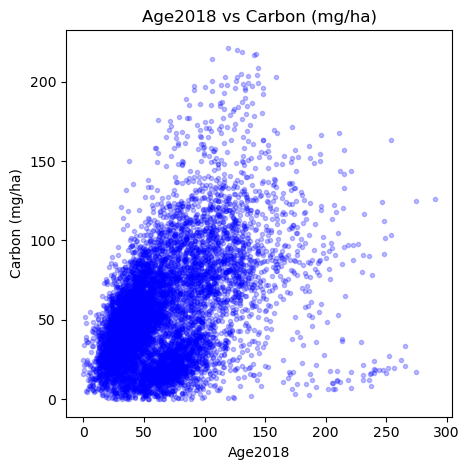

In [202]:
importance = pd.Series(
    carbon_rf.best_estimator_._final_estimator.feature_importances_,
    carbon_rf.best_estimator_.feature_names_in_,
).sort_values(ascending=False)
print('Feature Importance:')
print(importance, '\n')

# Displaying all the Data
print('Feature with Highest Importance: ', importance.index[0])
plot1 = plt.scatter(USFS_forest[importance.index[0]], USFS_forest['Carbon (mg/ha)'], label = 'Observed', color = 'blue', marker='.', alpha=0.25)
plt.gca().set_aspect(aspect=1/plt.gca().get_data_ratio()) # Setting the graph(s) to be a one to one ratio (square)
plt.ylabel('Carbon (mg/ha)')
plt.xlabel(importance.index[0])
plt.title(importance.index[0]+' vs Carbon (mg/ha)')
# plt.legend(handles=[plot1], loc='best',)
plt.tight_layout()
plt.show()

## Best Estimator Parameters

In [203]:
print('Best Estimator & Parameters:')
print('Score: ', round(r2_score(model_data.get_y()[1], pred), 3))
print(carbon_rf.best_params_, '\n')
print(results.loc[carbon_rf.best_index_])

Best Estimator & Parameters:
Score:  0.654
{'scale__n_quantiles': 1000, 'model__n_estimators': 338, 'model__min_samples_split': 53, 'model__min_samples_leaf': 34, 'model__max_features': 46, 'model__max_depth': 460} 

mean_fit_time                                                              6.687921
std_fit_time                                                               0.448032
mean_score_time                                                             0.02983
std_score_time                                                             0.002376
param_scale__n_quantiles                                                       1000
param_model__n_estimators                                                       338
param_model__min_samples_split                                                   53
param_model__min_samples_leaf                                                    34
param_model__max_features                                                        46
param_model__max_depth     

## Saving the model (in binary) to a file 

In [204]:
with open('./savedModels/'+'model_'+'carbon'+'_'+str(round(r2_score(model_data.get_y()[1], pred), 4))+'.pkl', 'wb') as savefile: # Saving model to a file so that it could be recalled later
    pickle.dump(carbon_rf, savefile)

if not pathlib.Path('./savedModels/'+'model_'+'carbon'+'_param.txt').is_file(): # If file does not exist
    with open('./savedModels/'+'model_'+'carbon'+'_param.txt', 'w') as paramFile: # Create new file
        paramFile.write(str(time.ctime())+' - '+'model_'+'carbon'+str(round(r2_score(model_data.get_y()[1], pred), 4))+' '+str(carbon_rf.best_params_)+'\n\n')
else: # If the file already exists
    with open('./savedModels/'+'model_'+'carbon'+'_param.txt', 'a') as paramFile: # Append to file
        paramFile.write(str(time.ctime())+' - '+'model_'+'carbon'+str(round(r2_score(model_data.get_y()[1], pred), 4))+' '+str(carbon_rf.best_params_)+'\n\n')

print('Save completed!')

Save completed!


### Writing Predicted values to a file alongside our filtered original dataset

In [205]:
outputFile = 'data/csv_files/USFS_forest_predicted_carbon.csv'

USFS_forest_predicted = USFS_forest
USFS_forest_predicted['predicted_carbon'] = model.predict(
    USFS_forest[[
        'NDVI_Jun13', 
        'NDMI_Jun13', 
        'PRISM_ppt', 
        'PRISM_tave', 
        'Age2018', 
        # 'Lattitude',
        # 'Longitude',
    ]]
)

USFS_forest_predicted.to_csv(outputFile)